# Take Your First Step in Medical Image Classification #

**<font size="3">Artificial intelligence (AI) is getting importance day by day in healthcare. Again, Deep already shows its superhuman accuracy on image classification. So, AI enthusiasts are jumping to develop computer-aided detection systems to diagnose various diseases. Today, We will build a model to detect pediatric/child pneumonia. This kernel is for beginners who want to jump in medical image classification. We will pick a dataset containing pneumonia (bacterial and viral) and normal images. We will do binary (two-class) classification so our model will detect pneumonia from the test set. Data load and preprocessing, Training, and evaluation are basic steps of any classification model. We will follow these steps. There are various ways to preprocess any dataset. We want to do it an easy way so we think beginners can easily understand it. Beginners should follow the comments for better understading. If you don't understand anything or you have more queries, feel free to contact me. Email: sawrupkhan@yahoo.com</font>**

In [1]:
#import necessary libraries when needed
import os
import numpy as np
import pandas as pd
import pathlib
import imageio



# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
DEVMODE = os.getenv("KAGGLE_MODE") == "DEV"
print(f"DEV MODE: {DEVMODE}")
EPOCHS = 2 if DEVMODE else 1
print(f"EPOCHS: {EPOCHS}")

DEV MODE: True
EPOCHS: 2


**<font size="3">Now , We jump to get insight of the dataset.
Dataset has three folders (train , val ,test).</font>**


In [3]:
# Exploring dataset 
base_dir = '../input/chest-xray-pneumonia/chest_xray/'

train_pneumonia_dir = base_dir+'train/PNEUMONIA/'
train_normal_dir=base_dir+'train/NORMAL/'

test_pneumonia_dir = base_dir+'test/PNEUMONIA/'
test_normal_dir = base_dir+'test/NORMAL/'

val_normal_dir= base_dir+'val/NORMAL/'
val_pnrumonia_dir= base_dir+'val/PNEUMONIA/'

train_pn = [train_pneumonia_dir+"{}".format(i) for i in os.listdir(train_pneumonia_dir) ]
train_normal = [train_normal_dir+"{}".format(i) for i in os.listdir(train_normal_dir) ]

test_normal = [test_normal_dir+"{}".format(i) for i in os.listdir(test_normal_dir)]
test_pn = [test_pneumonia_dir+"{}".format(i) for i in os.listdir(test_pneumonia_dir)]

val_pn= [val_pnrumonia_dir+"{}".format(i) for i in os.listdir(val_pnrumonia_dir) ]
val_normal= [val_normal_dir+"{}".format(i) for i in os.listdir(val_normal_dir) ]

print ("Total images:",len(train_pn+train_normal+test_normal+test_pn+val_pn+val_normal))
print ("Total pneumonia images:",len(train_pn+test_pn+val_pn))
print ("Total Nomral images:",len(train_normal+test_normal+val_normal))


Total images: 5856
Total pneumonia images: 4273
Total Nomral images: 1583


## Dataset Preprocessing & Visualization ## 
**<font size="3">The dataset is small. So, We follow 80%, 15%, 5% split. Besides, dataset is clearly imbalanced. We will take care of it later. </font>**

In [4]:
# Dataset Splitting (train 80% , test 15% and validation 5% )

# Gathering all pneumina and normal chest X-ray in two python list
pn = train_pn + test_pn + val_pn
normal = train_normal + test_normal + val_normal

# Spliting dataset in train set,test set and validation set.

train_imgs = pn[:3418]+ normal[:1224]  # 80% of 4273 Pneumonia and normal chest X-ray are 3418 and 1224 respectively.
test_imgs = pn[3418:4059]+ normal[1224:1502]
val_imgs = pn[4059:] + normal[1502:]

print("Total Train Images %s containing %s pneumonia and %s normal images" 
      % (len(train_imgs),len(pn[:3418]),len(normal[:1224])))
print("Total Test Images %s containing %s pneumonia and %s normal images"
      % (len(test_imgs),len(pn[3418:4059]),len(normal[1224:1502])))
print("Total validation Images %s containing %s pneumonia and %s normal images" 
      % (len(val_imgs),len(pn[4059:]),len(normal[1502:])))



import random

random.shuffle(train_imgs)
random.shuffle(test_imgs)
random.shuffle(val_imgs)

Total Train Images 4642 containing 3418 pneumonia and 1224 normal images
Total Test Images 919 containing 641 pneumonia and 278 normal images
Total validation Images 295 containing 214 pneumonia and 81 normal images


In [5]:
#showing a file name from test set
print(test_imgs[5])

../input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-0578-0001.jpeg


**<font size="3">Loading each image and their label into array</font>**

In [6]:
import cv2
img_size = 224

def preprocess_image(image_list):
    
    X = [] # images
    y = [] #labels (0 for Normal or 1 for Pneumonia)
    count=0
    
    for image in image_list:
        
        try:

            img = cv2.imread(image,cv2.IMREAD_GRAYSCALE)
            
            img=cv2.resize(img,(img_size,img_size),interpolation=cv2.INTER_CUBIC)
            
            #convert image to 2D to 3D 
            img = np.dstack([img, img, img])
            
            #convrt greyscale image to RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Normalalize Image
            img = img.astype(np.float32)/255.
            
            count=count+1

            X.append(img) 
            
            
        except:
            continue
        #get the labels 
        if 'NORMAL' in image:
            y.append(0)
            
        elif 'IM' in image:
            y.append(0)
            
        elif 'virus' or 'bacteria' in image:
            y.append(1)
            
    
    return X, y

In [7]:

X, y = preprocess_image(train_imgs)

print("Total Train Images %s" % len(X))
print("Total Train Labels %s" % len(y))


Total Train Images 4642
Total Train Labels 4642


In [8]:
# Check all the images getting labels or not
arr=y	
uniqueValues, occurCount = np.unique(arr, return_counts=True)
 
print("Unique Values : " , uniqueValues)
print("Occurrence Count : ", occurCount)


Unique Values :  [0 1]
Occurrence Count :  [1224 3418]


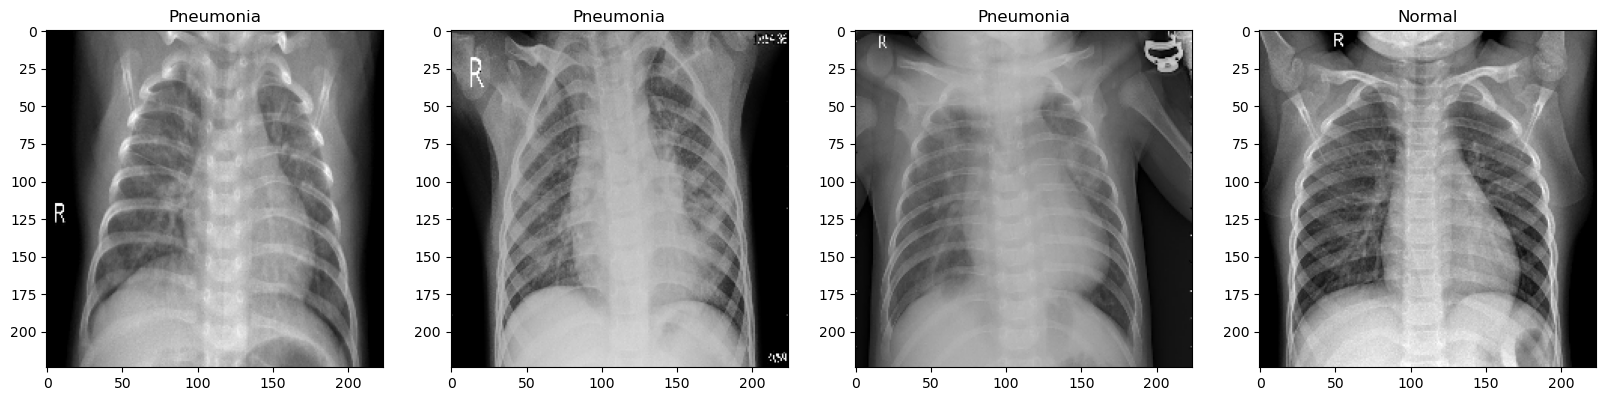

In [9]:
# Display some images from train set
# Feel free to show more image by changing the values

import matplotlib.pyplot as plt 

fig = plt.figure(figsize=(20, 5))
k=1
for i in range(4):
    a = fig.add_subplot(1, 4, k)
    if (y[i]==0):
        a.set_title('Normal')
    else:
        a.set_title('Pneumonia')
        
    plt.imshow(X[i])
    k=k+1;
    


In [10]:
# get the labels for test set

P, t = preprocess_image(test_imgs)

print("Total Test Images %s" % len(P))
print("Total Test Labels %s" % len(t))

Total Test Images 919
Total Test Labels 919


In [11]:
arr=t	
uniqueValues, occurCount = np.unique(arr, return_counts=True)
 
print("Unique Values : " , uniqueValues)
print("Occurrence Count : ", occurCount)

Unique Values :  [0 1]
Occurrence Count :  [278 641]


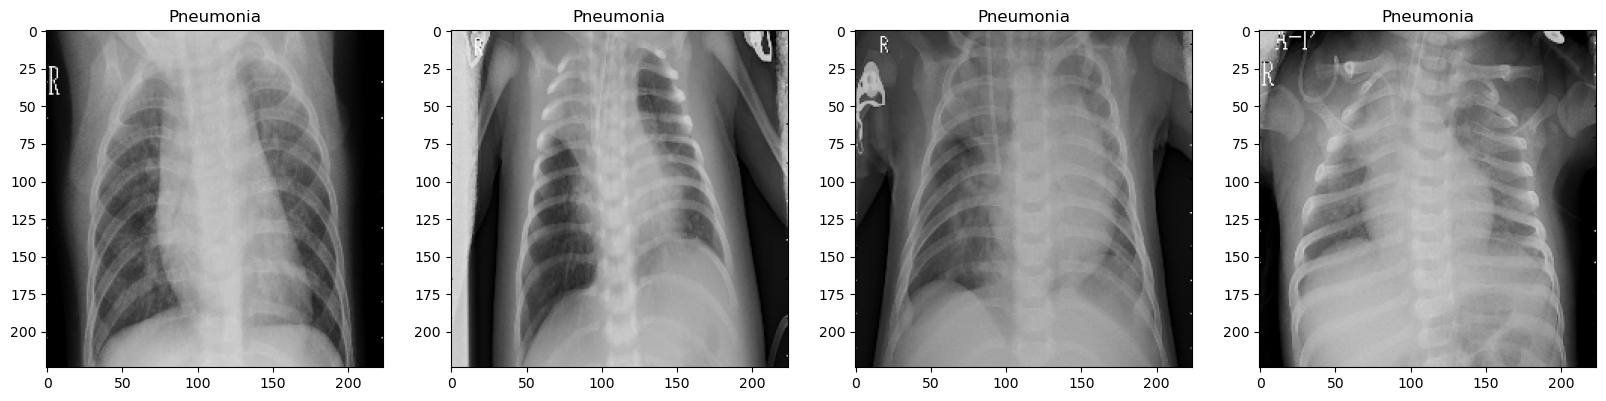

In [12]:
# now displaying some images from test set
# Feel free to show more image by changing the values

import matplotlib.pyplot as plt 

fig = plt.figure(figsize=(20, 5))
k=1
for i in range(4):
    a = fig.add_subplot(1, 4, k)
    if (t[i]==0):
        a.set_title('Normal')
    else:
        a.set_title('Pneumonia')
        
    plt.imshow(P[i])
    k=k+1;

In [13]:
# get the labels for validation set

K, m = preprocess_image(val_imgs)

print("Total Validation Images %s" % len(K))
print("Total Validation Labels %s" % len(m))

Total Validation Images 295
Total Validation Labels 295


In [14]:


arr=m

 
# Get a tuple of unique values & their frequency in numpy array
uniqueValues, occurCount = np.unique(arr, return_counts=True)
 
print("Unique Values : " , uniqueValues)
print("Occurrence Count : ", occurCount)

Unique Values :  [0 1]
Occurrence Count :  [ 81 214]


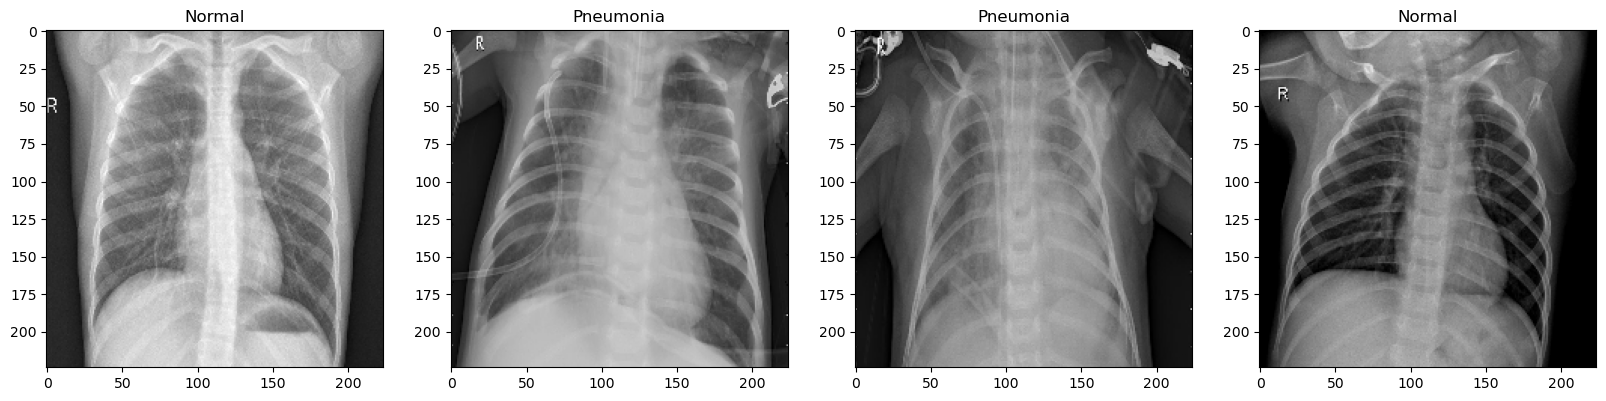

In [15]:
# now displaying some images from validation set
# Feel free to show more image by changing the values

import matplotlib.pyplot as plt 

fig = plt.figure(figsize=(20, 5))
k=1
for i in range(4):
    a = fig.add_subplot(1, 4, k)
    if (m[i]==0):
        a.set_title('Normal')
    else:
        a.set_title('Pneumonia')
        
    plt.imshow(K[i])
    k=k+1;

**<font size="4">Let's count and show the quantity of image in each set by counplot from Seaborn </font>**

      Train  Test  Val
0         1   1.0  0.0
1         1   1.0  1.0
2         1   1.0  1.0
3         0   1.0  0.0
4         0   1.0  0.0
...     ...   ...  ...
4637      1   NaN  NaN
4638      1   NaN  NaN
4639      1   NaN  NaN
4640      1   NaN  NaN
4641      1   NaN  NaN

[4642 rows x 3 columns]


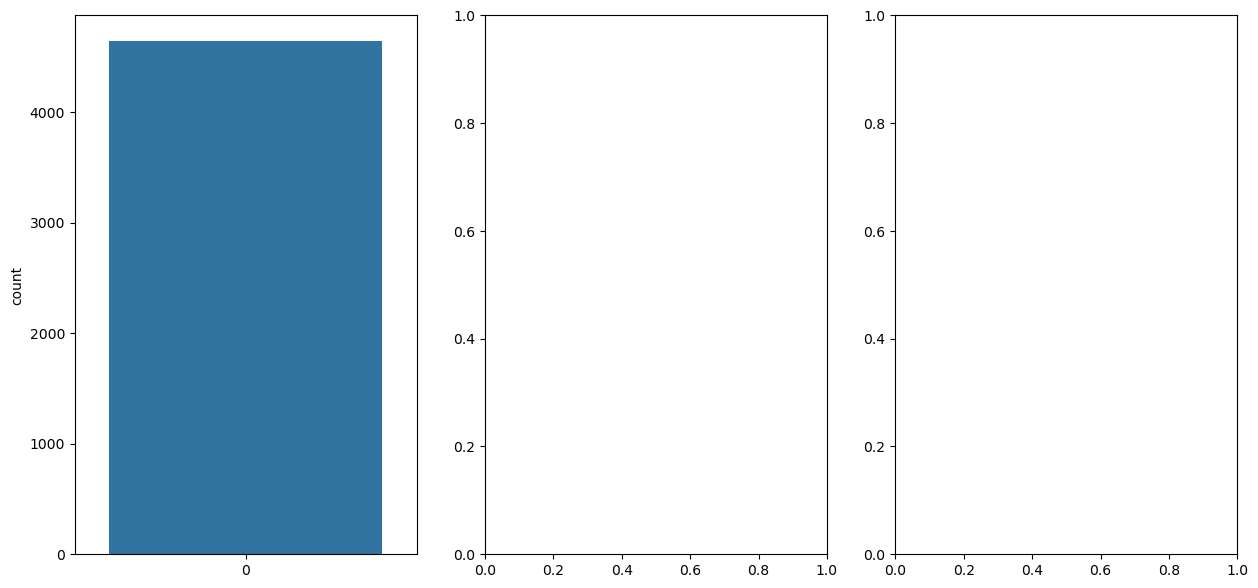

In [16]:
import seaborn as sns


df=pd.DataFrame()
df['Train']=y
df['Test']=pd.Series(t)
df['Val']=pd.Series(m)

print(df)

fig, ax =plt.subplots(1,3,figsize=(15,7))
sns.countplot(df['Train'], ax=ax[0])
# ax[0].set(ylim=(0, 3500))


# sns.countplot(df['Test'], ax=ax[1])
# ax[1].set(ylim=(0, 3500))

# sns.countplot(df['Val'], ax=ax[2])
# ax[2].set(ylim=(0, 3500))

# fig.show()
plt.show()

## Dealing with class imbalance ##

**<font size="3">We can solve the class imbalance problem with several methods. One of the simplest ways to solve the class imbalance is to simply provide a weight for each class which places more emphasis on the minority classes so CNN model can learn equally from all classes. Here, we employ sklearn compute class weight function to set weight for each class. </font>**


In [17]:
from sklearn.utils import class_weight


class_weights = class_weight.compute_class_weight('balanced',
                                                 classes=np.unique(y), # here, y contains train set label
                                                 y=y)
class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: 1.8962418300653594, 1: 0.679052077238151}


In [18]:
# import seaborn as sns
# import gc

# train_imgs = train_pn[:3875]+ train_normal[:1341]
# del train_imgs
# gc.collect()

X_train = np.array(X)
# y_train = np.array(y)
# X_test = np.array(P)
# y_test = np.array(t)
# X_val = np.array(K)
# y_val = np.array(m)

# print(X_train.shape)
# print(y_train.shape)
# print(X_test.shape)
# print(y_test.shape)
# print(X_val.shape)
# print(y_val.shape)



In [19]:
y_train = np.array(y)

In [20]:
X_test = np.array(P)

: 

: 

In [ ]:
y_test = np.array(t)

In [ ]:
X_val = np.array(K)
y_val = np.array(m)


<font size="6"> Training </font>




**<font size="3">We can say that training phase starts from here. We will use a batch size of 32. Batch size should be a power of 2 (4, 8, 16, 32, 64, 128, 256,....).
The batch size 32 means the model will train 32 training samples and then update its parameters once.
Batch training is faster and memory efficient.</font>**

In [ ]:
# clear memory
# del X
# del y
# gc.collect()

#get the length of the train and validation data
ntrain = len(X_train)
nval = len(X_val)

batch_size = 2

NameError: name 'X_val' is not defined

## Image Augmentation ##
**<font size="3">Lets build an input pipline for model with the augmentation technique.
We artificially increase the dataset with augmentation technique, since we are using a small dataset. 
It also helps prevent overfitting. Feel free to study various augmentation techniques in internet. </font>**

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(  rotation_range=7,
                                     width_shift_range=0.05,
                                     height_shift_range=0.05,
                                     shear_range=0.2,
                                     zoom_range=0.45,
                                     horizontal_flip=True)
                                   
val_datagen = ImageDataGenerator(zoom_range=0.45)  

In [ ]:
#Create the image generators
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)

In [ ]:
# Set image Size
img_size =224

## Train full train set with MobileNet  ##

**<font size="3"> We don't build a convolutional neural network (CNN) architecture from scratch here. Instead, we use a pretrainted CNN architecture called MobileNet. </font>**

In [ ]:
from keras import layers
from keras import models
from keras import optimizers
from keras.applications import *
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import img_to_array, load_img
from keras.models import Model
from keras import backend as K

# Create the base pre-trained model
# Weights should be none becuase we don't need to train with any pre-trained weights here

base_model = MobileNet(weights=None, include_top=False,input_shape=(img_size, img_size, 3)) 

x = base_model.output

# Add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# Add a logistic layer
predictions = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)
# Compile model
model.compile(optimizer='adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])

In [ ]:
# We can see details of  MobileNet architecure's details
model.summary()

**<font size="3">Keep your GPU on or training time will be so high. Check your kaggle notebook's settings.**</font>

In [ ]:

# We train for 64 epochs 
history = model.fit_generator(train_generator,
                              steps_per_epoch=ntrain // batch_size,
                              epochs=EPOCHS,
                              validation_data=val_generator,
                              validation_steps=nval // batch_size,
                              class_weight =class_weights,
)

**<font size="3">Plot how validation accuracy and loss are increasing  against training accuracy and loss.</font>**

In [ ]:
# Lets plot the train and val curve
# Get the details form the history object
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

## Estimation of classification performance / Result ##
**<font size="3">We will check our model classification ability using some evaluation matrices. It is very important to use multiple evaluation metrics to evaluate your model to ensure that the model is operating correctly and optimally. We will check our model's performance by Accuracy, Recall, Precision, F1 and AUC score. Feel free to search in google to know more about these matrices. </font>**

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

preds = model.predict(X_test)

acc = accuracy_score(y_test, np.round(preds))*100
cm = confusion_matrix(y_test, np.round(preds))

tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\n============TEST METRICS=============')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((history.history['binary_accuracy'][-1])*100, 2)))

In [ ]:
import seaborn as sns
sns.heatmap(cm, annot=True, fmt="d",)

**<font size="3">The ROC (receiver operating characteristic) curve indicates the diagnostic accuracy and porformance of a model.
We show the ROC curve and also calculate AUC score.</font>**

In [ ]:
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.metrics import auc

fpr , tpr , thresholds = roc_curve ( y_test , preds)
auc_keras = auc(fpr, tpr)
print("AUC Score:",auc_keras)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc_keras)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

**<font size="3">We see the model achieves great evaluation scores. It indicates that our model performs very well. But these scores can be increased. Beginners should apply different architectures. Transfer learning can be applied along with different augmentation techniques. If this kernel helps you, you can give an upvote. Stay tuned for more and Happy Coding !! </font>**